In [1]:
%matplotlib nbagg
import pandas as pd
import os, sys
import numpy as np
from collections import defaultdict
from caseDetection import detect_case
#import matplotlib as mpl
#mpl.use("GTK3cairo")
#import matplotlib.pyplot as plt
#plt.plot([1,2,3,4],'*-')

<IPython.core.display.Javascript object>


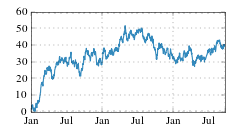

In [2]:
# test plot
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
ts = ts.cumsum()
ts.plot()

In [7]:
df_all = pd.read_pickle("data/detected_case_all_Apr12.pkl")

In [8]:
df_all.head(1)

,ipids,ts,diff_list,retransmit_times,gIP,sIP,port,k1,k2,country,first_ts,diff_p1,diff_p2,domain,subcat,case,intervention,pvalue
138000,"[37236, None, 37241, 37244, 37246, 37247, 3725...","[60, 64, 70]","[1, None, None, 2, 1, 0, 3, 0, 4, 2, 0, 2, 1, ...","[0, 4, 10]",61.203.195.52,206.207.84.93,80,10,40,JP,60,48,60,bodybuilding.com,shopping,2,20.403612,2.483276e-78


## Sanitize by case
- remove case = 0, -1, 4
- case = -1 default: why??
- treat case -1 as 0 (did not enter else)

In [9]:
#%load caseDetection.py

In [10]:
df_case_default = df_all[df_all['case'] == -1]
x = df_case_default.ix[138003,:]
print x

ipids               [59848, 59851, 59856, 59861, 59863, 59866, 598...
ts                                                       [60, 64, 70]
diff_list           [1, 2, 4, 4, 1, 2, 3, 1, 1, 1, 5, 3, 6, 2, 1, ...
retransmit_times                                           [0, 4, 10]
gIP                                                       59.53.57.86
sIP                                                     206.207.84.93
port                                                               80
k1                                                                 10
k2                                                                 40
country                                                            CN
first_ts                                                           60
diff_p1                                                            56
diff_p2                                                            56
domain                                               bodybuilding.com
subcat              

In [11]:
detect_case(x['gIP'],  x['sIP'], x['diff_list'], x['ts'], None, 20, True)

ir.pvalues 1.0 0.01
59.53.57.86 206.207.84.93 0 order: (0, 0, 0)
removed additive outliers: [59, 119]
intervention: 39.907071
interventions: [39.618182, 39.451515, 39.907071]
null-interventions: [10.0, 40.0]
p-values: [1.000000, 0.429390]


(0, 0.42939048148946846, 39.90707070707143)

In [12]:
df_bad = df_all [  df_all['case'].isin([0, -1, 4])  ]
df_good = df_all [  df_all['case'].isin([1,2,3])  ]

In [13]:
len(df_good)

197106

In [14]:
len(df_bad)

42703

# DATA ANALYSIS
- per country num obs
- per country num unique sIPs tested

In [15]:
# meaningful num of countries
THRESHOLD = 400

In [16]:
# per country, how many unique sIPs
df_unique_sIP_per_country = df_all.groupby(['country'])['sIP'].unique().apply(lambda x:len(x))
df_current = df_unique_sIP_per_country[df_unique_sIP_per_country > THRESHOLD]

#### Take all cases, don't ignore error

In [17]:
valid_countries = df_current.index
print valid_countries, len(valid_countries)

# filter df_good to only valid countries
# remove extra columns
df = df_all[  df_all['country'].isin(valid_countries)   ] [['sIP', 'gIP', 'country', 'diff_list', 'domain', 'subcat', 'case']]

Index([u'BR', u'CA', u'CN', u'CR', u'CZ', u'DE', u'DK', u'ES', u'FR', u'GB', u'ID', u'IN', u'IT', u'JP', u'KR', u'MX', u'MY', u'NL', u'NO', u'PH', u'PL', u'RU', u'SE', u'TH', u'TW', u'UA', u'US', u'ZA'], dtype='object') 28


In [18]:
df_obs_per_country = df.groupby('country').count().reset_index().sort('sIP', ascending=False)
# number of measurements per country
df_obs_per_country[['country', 'sIP']]

,country,sIP
26,US,34840
13,JP,33986
14,KR,29564
22,SE,20386
8,FR,19674
2,CN,19363
5,DE,13209
20,PL,8601
0,BR,7197
9,GB,4278


In [19]:
# num of unique sIPs per country
df_unique_sIP_per_country = pd.DataFrame(df.groupby('country')['sIP'].unique().apply(lambda x: len(x)).sort(inplace=False, ascending=False))
df_unique_sIP_per_country.to_html('results/unique_sIP_per_country-filtered400.htm')
df_unique_sIP_per_country

,sIP
country,
SE,555
PL,554
ES,512
UA,501
NO,492
US,470
JP,469
KR,469
CN,469


### case 1, 2, 3, and errors per (country, subcat)

In [20]:
grouped_by_country_subcat_case = df.groupby(['country', 'subcat', 'case'])

In [21]:
count_per_country_subcat_case = grouped_by_country_subcat_case.count()

In [22]:
# replace nan with 0
df_case_count = count_per_country_subcat_case.unstack(level=-1)['sIP']
df_case_count['total'] = df_case_count.sum(axis=1)
df_case_count.to_html('results/cases_per_country_subcat-filtered400.htm')
df_case_count

case                     -1    0    1     2    3    4  total
country subcat                                              
BR      adult            14   40   14   265   46   90    469
        arts             31   43    6   337   32   89    538
        business         14   19    9   265    8   41    356
        circum           10    9    2   172   14   44    251
        computers        12   26    9   201   57   55    360
        games            13   26   23   215   75   59    411
        health           27   35   26   191   40   43    362
        home             38   21    8   205   34   73    379
        kids_and_teens    7   12    4   173    2   39    237
        news              5   43    8   139   15   33    243
        recreation       49   62   56   308   19   41    535
        reference        16   21    3   277   31   86    434
        regional         13   14   26   131    5   32    221
        science          16   42   11   305   63   74    511
        shopping         42   25    4   176    8   30    285
        society          40   45    6   284   86   79    540
        sports           11   24   12   220    3   29    299
        vpn               7   11    1   153   40   52    264
        world            22   71   18   305   32   54    502
CA      adult             5    6   12   144   26    9    202
        arts             11   12   13   185   14    6    241
        business          4    7   11   129    4    5    160
        circum            2    3    8    85   10    2    110
        computers         8    9    3   117   31    8    176
        games             2   13   19   103   46    5    188
        health           20    9    9   121   27    9    195
        home             10    6   15   129   23    6    189
        kids_and_teens    1    5    7   105    4    3    125
        news              3   18    9    75    8    6    119
        recreation       24   18   21   162   11   10    246
...                     ...  ...  ...   ...  ...  ...    ...
US      kids_and_teens   44   64   27   741   64   78   1018
        news             45  183   36   721  108  151   1244
        recreation      241  218  243  1510  160  113   2485
        reference       141  168   25  1488  199  240   2261
        regional         72   41  137   654   48   49   1001
        science         133  166   36  1726  360  276   2697
        shopping        188   89   28   849   78  102   1334
        society         160  149   94  1414  533  212   2562
        sports           60   65  102   958   43   46   1274
        vpn              56   53    9   784  299  179   1380
        world           120  372   62  1434  214  157   2359
ZA      adult             1    3    1    43    9    9     66
        arts              8    7    3    57    3    9     87
        business          4    2    1    44  NaN    8     59
        circum            1  NaN  NaN    26    5    3     35
        computers         2    3  NaN    27    7    8     47
        games             2    2    2    34    6    5     51
        health          NaN    4    5    35    8    4     56
        home              4    6    5    31    1    9     56
        kids_and_teens    2    4    3    25    1    1     36
        news              1    5    1    18    5  NaN     30
        recreation        5    9    5    37    5    5     66
        reference       NaN    3    3    48  NaN    5     59
        regional          1  NaN    3    21  NaN    5     30
        science           2    4    4    48    4   11     73
        shopping          1    4    4    35    2    4     50
        society           3   14   13    46    8    3     87
        sports          NaN    3    3    31    3    7     47
        vpn             NaN    1  NaN    28    8    2     39
        world             3    2    4    46    5   15     75

[532 rows x 7 columns]

#### Censorship by country for each subcat
- create num(subcat) bar plots comparing case2 with (case1 + case3)

In [23]:
# clear all except df_case_count
#del df, df_bad, df_case_default, df_current, df_good, df_merged_unique_cases, df_obs_per_country, df_redo
#del df_sIP_CO, df_temp, df_unique, df_unique_sIP_per_country

In [24]:
group_by_subcat = df_case_count.reset_index().groupby('subcat')

### Per Subcategory Analysis, including errors

In [25]:
def get_ratios(subcat, indices):
    #if subcat == 'all':
        
    temp_df = df_case_count.ix[ group_by_subcat.groups[subcat] ].reset_index()
    temp_df['censored'] = temp_df[1]+temp_df[3]
    temp_df['unknown'] = temp_df[-1]+temp_df[0]+temp_df[4]
    temp_df = temp_df.rename(columns={2:'uncensored'})[['country', 'censored', 'uncensored', 'unknown']].set_index('country')

    # calculate ratios
    temp_df['total'] = temp_df.sum(axis=1)
    temp_df['ratio-censored'] = temp_df['censored']/(temp_df['total'])
    temp_df['ratio-uncensored'] = temp_df['uncensored']/(temp_df['total'])
    temp_df['ratio-unknown'] = temp_df['unknown']/(temp_df['total'])

    # replace no entries with 0
    df_country_case = temp_df.fillna(0)
    return df_country_case

In [26]:
country_case_per_subcat = defaultdict(int)

# iterate over groupby object, indices
for subcat, indices in group_by_subcat.groups.iteritems():
    country_case_per_subcat[subcat] = get_ratios(subcat, indices)
    print subcat, len(country_case_per_subcat[subcat])
    
df_country_case_subcat = pd.concat(country_case_per_subcat)

science 28
arts 28
regional 28
shopping 28
reference 28
business 28
world 28
kids_and_teens 28
computers 28
recreation 28
sports 28
society 28
games 28
adult 28
home 28
health 28
news 28
vpn 28
circum 28


In [27]:
all_results = list(df_country_case_subcat.columns)
print all_results

['censored', 'uncensored', 'unknown', 'total', 'ratio-censored', 'ratio-uncensored', 'ratio-unknown']


In [30]:
censorship_ratio = defaultdict(int)
for key in all_results:
    censorship_ratio[key] = df_country_case_subcat[key].unstack(0)
    censorship_ratio[key].to_html('results/ALL_Apr12_censorship_'+key+'.html')

In [29]:
censorship_ratio['ratio-censored']

,adult,arts,business,circum,computers,games,health,home,kids_and_teens,news,recreation,reference,regional,science,shopping,society,sports,vpn,world
country,,,,,,,,,,,,,,,,,,,
BR,0.127932,0.070632,0.047753,0.063745,0.183333,0.238443,0.182320,0.110818,0.025316,0.094650,0.140187,0.078341,0.140271,0.144814,0.042105,0.170370,0.050167,0.155303,0.099602
CA,0.188119,0.112033,0.093750,0.163636,0.193182,0.345745,0.184615,0.201058,0.088000,0.142857,0.130081,0.081818,0.095238,0.213439,0.100000,0.290749,0.082090,0.284615,0.171806
CN,0.198263,0.161004,0.095875,0.170915,0.439614,0.193097,0.169725,0.130823,0.086268,0.084211,0.135812,0.141815,0.140575,0.197884,0.146821,0.228942,0.085290,0.386881,0.174274
CR,0.253333,0.000000,0.000000,0.000000,0.000000,0.323077,0.191011,0.000000,0.000000,0.000000,0.131868,0.134146,0.078431,0.000000,0.195652,0.000000,0.000000,0.000000,0.130841
CZ,0.181818,0.000000,0.000000,0.000000,0.000000,0.306122,0.206897,0.103448,0.245614,0.097561,0.146667,0.071429,0.107143,0.105263,0.107692,0.337079,0.000000,0.000000,0.098592
DE,0.146996,0.060768,0.041016,0.081673,0.233645,0.293194,0.187079,0.131122,0.052154,0.155000,0.115297,0.077441,0.172805,0.155039,0.115789,0.216650,0.063315,0.210037,0.153084
DK,0.104651,0.000000,0.000000,0.000000,0.236364,0.278689,0.218182,0.000000,0.052632,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ES,0.080460,0.070352,0.030612,0.150538,0.229508,0.235714,0.182857,0.120253,0.142857,0.134021,0.144654,0.137363,0.168831,0.130435,0.078261,0.229412,0.091954,0.270833,0.133803
FR,0.179178,0.100440,0.013786,0.101124,0.230052,0.260989,0.168709,0.087945,0.000000,0.101549,0.046005,0.075136,0.093023,0.141010,0.059013,0.263343,0.039604,0.248939,0.105218
